HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344
HD 73344


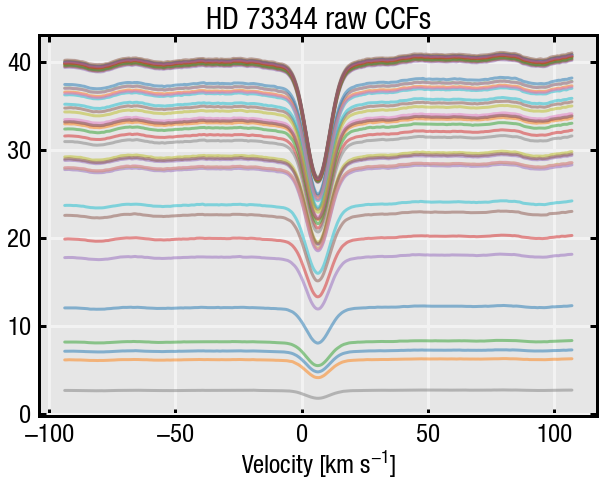

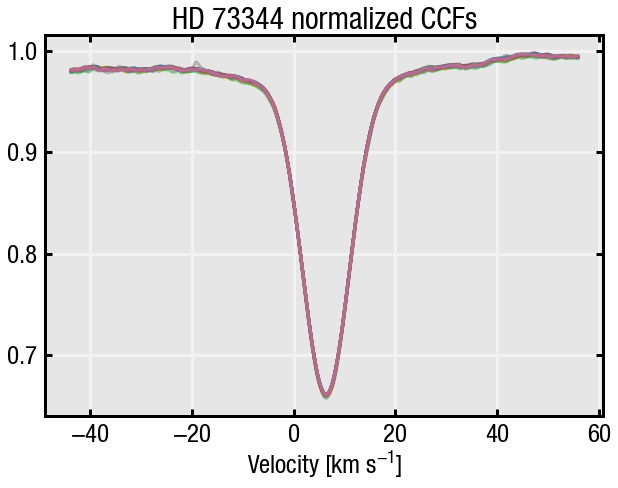

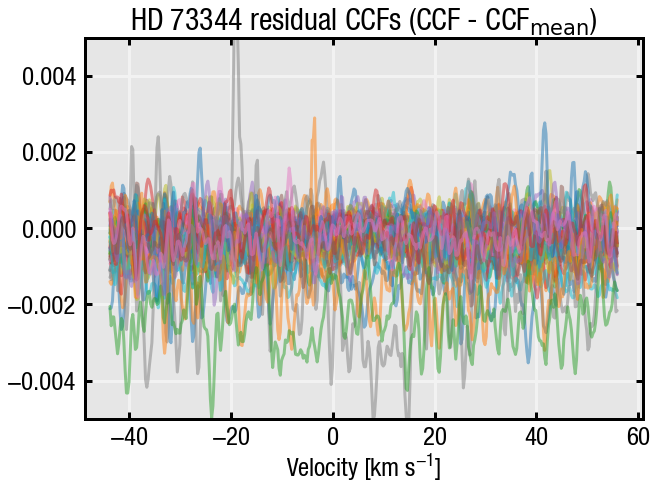

In [56]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from astropy.io import fits
import glob
# #---------------------------------------------


# package import and directory handling
#--------------------------------------
import os
from pathlib import Path
import sys

# sort out paths
local_path = Path.home()
file_path = os.path.join(os.path.join(local_path,'Google Drive'),'NEID_DEV')
prv_package_path = os.path.join(file_path,'python_packages_prv')
sys.path.append(prv_package_path) # add path to package search

from PRVccf.libs.fit_gaussian_to_ccf import fit_gaussian_to_ccf
#-----------------------------------------

# plotting preamble
#-----------------------------------------
%matplotlib inline

# sort out paths
local_path = Path.home()
plot_path = os.path.join(os.path.join(local_path,'Google Drive'),'stylelib')
plot_style = os.path.join(plot_path, 'main_grid.mplstyle')
plt.style.use(plot_style)
plt.rcParams['figure.figsize'] = [10,7]
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'  # changes only the mathcal subfamily
#-----------------------------------------


# file list of all L2 spectra for given night
#----------------------------------------------------------------
# night = '20210123'
# spec_path = os.path.join(os.path.join(os.path.join(file_path,'NEIDdata'),'nights'),night)

# target_name = 'Sun'
# night = '20210131'
# spec_path = os.path.join(os.path.join(os.path.join(os.path.join(file_path,'NEIDdata'),'solar_data'),'Level2'), night)

# target_name = 'HD 44420'
# night = '20201222'
# spec_path = os.path.join(os.path.join(os.path.join(os.path.join(file_path,'NEIDdata'),'commissioning_tests'),'data'), night)
# sci_ccf_cutoff = 30

# target_name = 'HD 10700'
# night = '20201220'
# spec_path = os.path.join(os.path.join(os.path.join(os.path.join(file_path,'NEIDdata'),'commissioning_tests'),'data'), night)
# sci_ccf_cutoff = 200

target_name = 'HD 73344'
night = '20210221'
spec_path = os.path.join(os.path.join(os.path.join(os.path.join(file_path,'NEIDdata'),'science_data'),'hd73344'), night)
sci_ccf_cutoff = 0.
#----------------------------------------------------------------

# full night's file list
#----------------------------------------------------------------

fits_files = os.path.join(spec_path,'*.fits')
spec_fits_files = [i for i in glob.glob(fits_files)]
# filter for fits files that are of specific target

files_target = []
jd_arr = []

# loop through each file in night, find which are of specified object
for spc_file in spec_fits_files:
    obj_name = fits.getheader(spc_file)['OBJECT']
    if obj_name == target_name:
        
        # load CCFs to check for quality
        ccfs = fits.getdata(spc_file, 'CCFS')
        ccf_all = np.nansum(ccfs, axis=0)
        
        # use only files that have CCF fluxes above specified cutoff
        if np.median(ccf_all > sci_ccf_cutoff):
            files_target.append(spc_file)

            # timestamp array
            jd_arr.append(fits.getheader(spc_file)['OBSJD'])

            # get systemic velocity offset (single value per target)
            qrv_offset = (fits.getheader(spc_file)['QRV'])
        # print(obj_name)
#----------------------------------------------------------------


# load CCF weights (currently stored as python file)
#----------------------------------------------------------------
# load python file with relative CCF weights, or construct the weights based on single exposure
ccf_weights = np.load('hd44420_ccf_weights.npy')

# normalize weights
ccf_weights /= np.nansum(ccf_weights)
#----------------------------------------------------------------

# sort files by jd
sort_inds = np.argsort(jd_arr)
files_target = np.asarray(files_target)[sort_inds]
jd_arr = np.asarray(jd_arr)[sort_inds]

# reconstruct CCF velocity array
vel_start = fits.getheader(files_target[0],'CCFS')['CCFSTART']
vel_step = fits.getheader(files_target[0],'CCFS')['CCFSTEP']
nvels = fits.getheader(files_target[0],'CCFS')['NAXIS1']
vel_arr = np.arange(vel_start + float(qrv_offset), vel_start + nvels * vel_step + float(qrv_offset), vel_step)

# narrow down to velocities in specified window
vel_span = 50. # km/s
vel_window = [-vel_span + float(qrv_offset),vel_span + float(qrv_offset)] # add relevant systemic offset
inds_vel = np.where((vel_arr > min(vel_window)) &(vel_arr < max(vel_window)))


# for each file, load summed CCF and store
summed_ccfs_weighted = []
summed_ccfs_unweighted = []
ccf_all_orders = []
rv_weighted_arr = []
rv_unweighted_arr = []
rv_file = []
rv_erf_arr = []
max_ccf_arr = []
for targ_fits in files_target:

    # print object just in case
    print(fits.getheader(targ_fits)['OBJECT'])
    
    # read in order-by-order CCFs
    ccfs = fits.getdata(targ_fits, 'CCFS')

    # clone for use later when adding relative weights
    ccfs_scaled = ccfs.copy()

    # proxy for overall stellar flux level
    max_ccf_arr.append(np.nanmax(ccfs))

    # load stellar spectrum and plot
    #spec = fits.getdata(targ_fits, 'SCIFLUX')
    #plt.plot(spec[80,2000:])
    #plt.show()

    # stash as-calculated RV from header
    rv_file.append(fits.getheader(targ_fits, 'CCFS')['CCFRVSUM'])

    # Loop through each echelle order, normalize each CCF, and reweight according to ccf_weights
    nords = ccfs.shape[0]
    ord_arr = []
    ccf_max_ords = []
    for ind, ord_n in enumerate(range(nords)):
        ccf_max_ords.append(np.nanmax(ccfs[ind, :]))

        # reweight order-by-order CCFs
        ccf_sum = np.nansum(ccfs[ind, :])
        ccfs_scaled[ind,:] = (ccfs[ind,:] / ccf_sum) * (ccf_weights[ind])
        if np.nanmedian(ccfs[ind, :] > 0.):
            ord_arr.append(ord_n)

    # sum weighted and unweighted CCFs for all orders
    ccf_all_weighted = np.nansum(ccfs_scaled, axis=0)
    ccf_all_unweighted = np.nansum(ccfs, axis=0)

    summed_ccfs_weighted.append(ccf_all_weighted/np.nanmax(ccf_all_weighted))
    summed_ccfs_unweighted.append(ccf_all_unweighted/np.nanmax(ccf_all_unweighted))
    
    # store matrix of order CCFs
    ccf_all_orders.append(ccfs)

    # fit gaussian to both weighted (ccf_all) and unweighted CCFs
    gaussian_fit, g_x, g_y, rv_weighted = fit_gaussian_to_ccf(vel_arr, ccf_all_weighted, 0., velocity_halfrange_to_fit=10.)
    gaussian_fit, g_x, g_y, rv_unweighted = fit_gaussian_to_ccf(vel_arr, ccf_all_unweighted, 0., velocity_halfrange_to_fit=10.)

    rv_weighted_arr.append(rv_weighted)
    rv_unweighted_arr.append(rv_unweighted)

    #plt.plot(vel_arr, ccf_all_weighted, linewidth=3,alpha=0.5)
    # fit_params, erf_model, erf_params = fit_erf_to_ccf(vel_arr, ccf_all_weighted, 0., velocity_halfrange_to_fit=10.)
    # rv_erf_arr.append(fit_params['centroid'])

    plt.plot(vel_arr, ccf_all_unweighted, linewidth=3,alpha=0.5)
    # plt.xlim(-20,20)
    # plt.show()

plt.title(target_name + ' raw CCFs')
plt.xlabel('Velocity [km s$^\mathcal{-1}$]')
plt.show()

summed_ccfs_weighted = np.asarray(summed_ccfs_weighted)
summed_ccfs_unweighted = np.asarray(summed_ccfs_unweighted)
ccf_all_orders = np.asarray(ccf_all_orders)

# compute averaged CCF for all orders, frames, with and without order weighting
avg_ccf_weighted = np.nansum(summed_ccfs_weighted, axis=0)
avg_ccf_weighted /= np.nanmax(avg_ccf_weighted)
avg_ccf_weighted = np.asarray(avg_ccf_weighted)

avg_ccf_unweighted = np.nansum(summed_ccfs_unweighted, axis=0)
avg_ccf_unweighted /= np.nanmax(avg_ccf_unweighted)
avg_ccf_unweighted = np.asarray(avg_ccf_unweighted)

# plot normalized CCFs
for ind in range(len(files_target)):
    ccf_frame = summed_ccfs_weighted[ind, :]
    plt.plot(vel_arr[inds_vel], ccf_frame[inds_vel], linewidth=3,alpha=0.5)

plt.title(target_name + ' normalized CCFs')
plt.xlabel('Velocity [km s$^\mathcal{-1}$]')
plt.show()

# calculate residual CCFs for all orders, and individual orders
# --------------------------------------------------
ccf_diff_weighted = []
ccf_diff_unweighted = []

ccf_diff_all_ord = []
ccf_minmax_weighted = []
ccf_minmax_unweighted = []
sigma_resid = []

# for each file, compute residual CCFs relative to average
for ind in range(len(files_target)):

    # weighted
    diff_ccf_weighted = summed_ccfs_weighted[ind, :] - avg_ccf_weighted
    ccf_minmax_weighted.append(np.nanmax(diff_ccf_weighted) - np.nanmin(diff_ccf_weighted))
    ccf_diff_weighted.append(diff_ccf_weighted[inds_vel])

    # unweighted
    diff_ccf_unweighted = summed_ccfs_unweighted[ind, :] - avg_ccf_unweighted
    ccf_minmax_unweighted.append(np.nanmax(diff_ccf_unweighted) - np.nanmin(diff_ccf_unweighted))
    ccf_diff_unweighted.append(diff_ccf_unweighted[inds_vel])

    # order by order residual CCFs
    ccf_diff_ord = []
    for ii, ord_n in enumerate(range(nords)):
        ccf_diff_ord.append(np.squeeze(ccf_all_orders[ind, ii, :]) - avg_ccf_weighted)
    ccf_diff_all_ord.append(ccf_diff_ord)

    # some rudimentary statistics
    sigma_ccf_diff = np.std(diff_ccf_weighted[inds_vel])
    sigma_resid.append(sigma_ccf_diff)
    plt.plot(vel_arr[inds_vel], diff_ccf_weighted[inds_vel], linewidth=3,alpha=0.5)

# order by order
ccf_diff_all_ord = np.asarray(ccf_diff_all_ord)
# --------------------------------------------------

plt.title(target_name + ' residual CCFs (CCF - CCF$_\mathrm{mean}$)')
plt.xlabel('Velocity [km s$^\mathcal{-1}$]')
plt.ylim(-0.005,0.005)
plt.show()


6.341727355326404

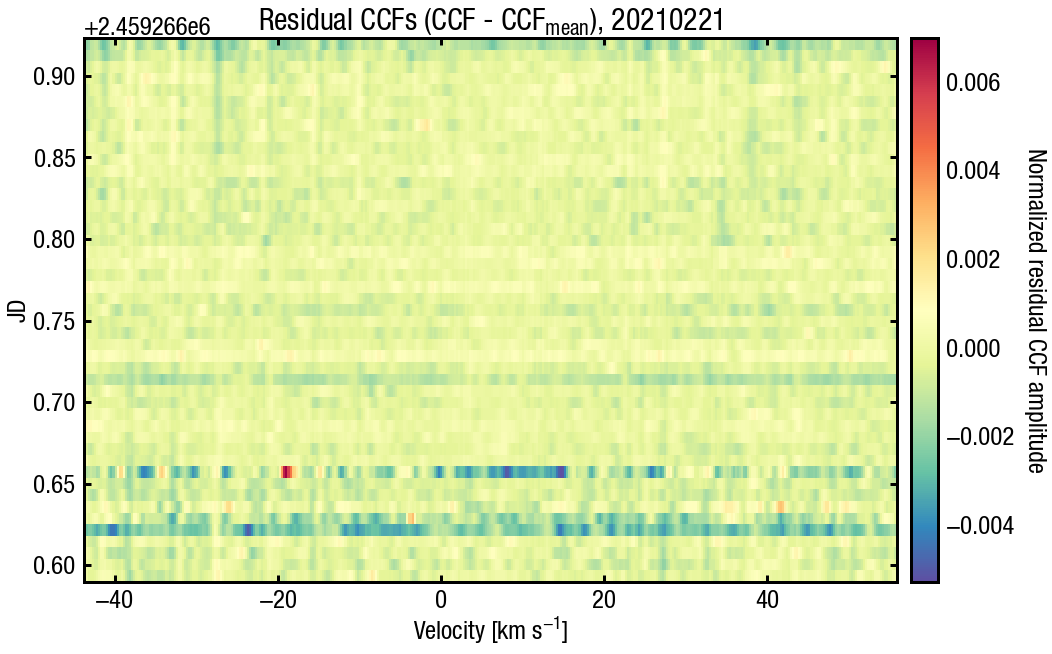

In [57]:
# plot heatmap of CCF residuals over time
plot_style = os.path.join(plot_path, 'main_grid.mplstyle')
plt.style.use(plot_style)
plt.rcParams['figure.figsize'] = [25,10]
plt.rcParams['grid.linewidth'] = 0

import matplotlib.pyplot as plt

ccf_diff_weighted = np.asarray(ccf_diff_weighted)

cmap = plt.cm.Spectral.reversed()

im = plt.imshow(ccf_diff_weighted, interpolation='None', extent=[min(vel_arr[inds_vel]), max(vel_arr[inds_vel]), min(jd_arr), max(jd_arr)],
                cmap=cmap, aspect=200)

plt.xlabel('Velocity [km s$^\mathcal{-1}$]')
plt.ylabel('JD')
plt.title('Residual CCFs (CCF - CCF$_\mathcal{mean}$), ' + night)

cbar = plt.colorbar(im,fraction=0.046, pad=0.01)
cbar.set_label('Normalized residual CCF amplitude', rotation=-90, labelpad=30)

# plt.hlines(np.arange(0,len(files_target), 3),min(vel_arr[inds_vel]), max(vel_arr[inds_vel]),'k', alpha=0.5, linewidth=4)
plt.show()
plt.rcParams['grid.linewidth'] = 3

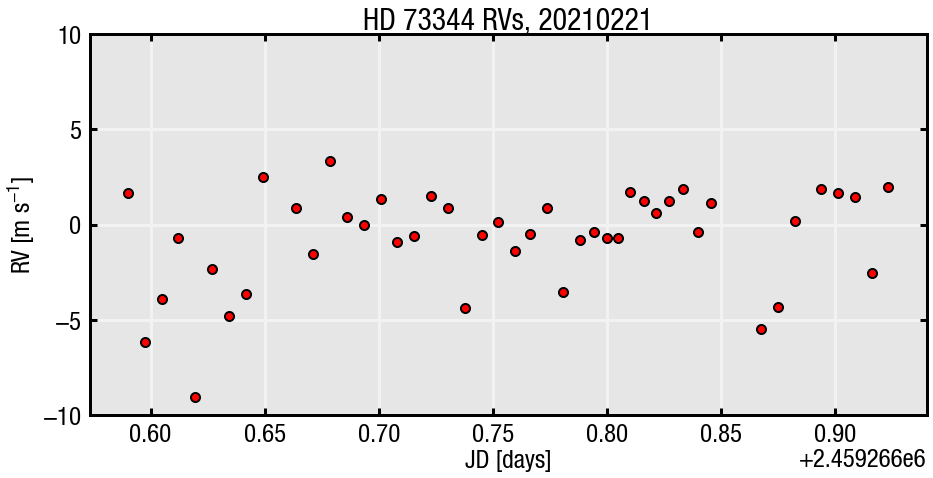

In [60]:
plt.rcParams['figure.figsize'] = [15,7]
plot_style = os.path.join(plot_path, 'main_grid.mplstyle')
plt.style.use(plot_style)
plt.rcParams['figure.figsize'] = [15,7]

plt.plot(jd_arr, (np.asarray(rv_file) - np.mean(rv_file))*1e3,'ko', markersize=10)
plt.plot(jd_arr, (np.asarray(rv_file) - np.mean(rv_file))*1e3,'ro', markersize=6)
plt.title(obj_name + ' RVs, ' + night)
plt.xlabel('JD [days]')
plt.ylabel('RV [m s$^\mathcal{-1}$]')
plt.ylim(-10,10)

plt.show()

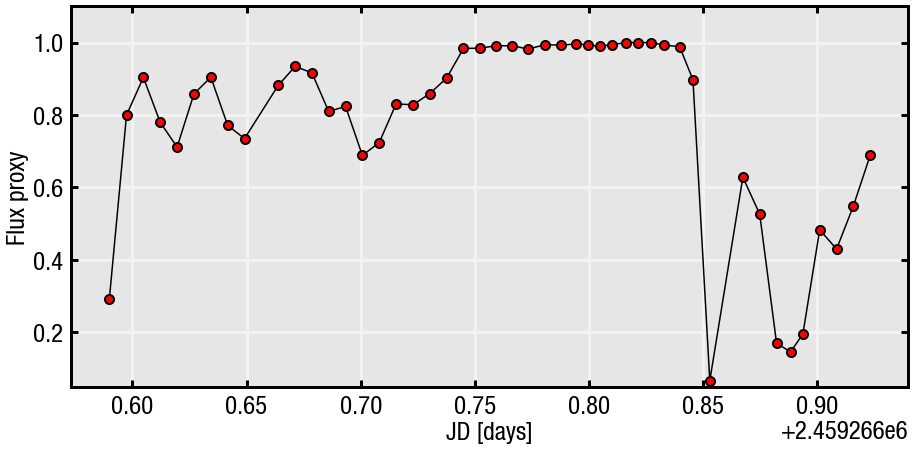

In [9]:
plt.rcParams['figure.figsize'] = [15,7]
plt.plot(jd_arr, max_ccf_arr / np.nanmax(max_ccf_arr),'-ko',markersize=10)
plt.plot(jd_arr, max_ccf_arr / np.nanmax(max_ccf_arr),'ro',markersize=6)
plt.xlabel('JD [days]')
plt.ylabel('Flux proxy')
plt.ylim(0.05,1.1)

plt.show()